In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from collections import Counter
import pickle

In [2]:
dataset_path_engineering = "C:\\Users\\hp-pc\\Desktop\\GRP\\sim_data\\engineering\\engineering_total\\engineering_total.csv"

In [3]:
df_engineering = pd.read_csv(dataset_path_engineering, index_col=False)

In [4]:
df_engineering = df_engineering.dropna()

num_trial = len(df_engineering[df_engineering['Termination'] == 1])
num_D_trial = len(df_engineering[df_engineering['Declare'] == 1])
num_TO_trial = len(df_engineering[df_engineering['Time_out'] == 1])

trial_start = []
trial_D_start = []

In [5]:
for i in range(df_engineering.shape[0]):
    if df_engineering['Time'].iloc[i] == 0:
        trial_start.append(i)
    if df_engineering['Termination'].iloc[i] == 1:
        trial_D_start.append(i)

In [6]:
df_engineering.pop('Declare')
df_engineering.pop('Termination')
df_engineering.pop('Time_out')
df_engineering.pop('Time')
df_engineering.pop('X')
df_engineering.pop('Y')
df_engineering.pop('Yaw')
df_engineering.pop('V')

0         1.16484
1         1.31895
2         1.41026
3         1.46168
4         1.48884
           ...   
689939    1.49992
689940    1.49989
689941    1.49981
689942    1.49970
689943    1.06647
Name: V, Length: 689944, dtype: float64

In [7]:
df_engineering

,Ux,Uy,Con,Detection,Yaw_c
0,1.86090,0.188174,0.003281,1,254.8910
1,1.85155,0.188182,0.176745,1,187.5780
2,1.84024,0.188210,0.000000,0,195.6840
3,1.82735,0.187599,0.000000,0,207.8320
4,1.81108,0.185014,0.000000,0,213.7260
...,...,...,...,...,...
689939,1.17485,-0.029356,0.000000,0,84.1618
689940,1.16211,-0.021375,0.000000,0,57.0642
689941,1.14909,-0.014092,0.000000,0,20.7931
689942,1.13718,-0.008005,0.000000,0,-17.3910


In [8]:
# convert negative yaw command to positive

def change_yaw(x):
    if x < 0:
        x += 360
    return x

df_engineering['Yaw_c'] = df_engineering['Yaw_c'].apply(change_yaw)
yaw_c1 = df_engineering.pop("Yaw_c")
yaw_c2 = yaw_c1 * np.pi / 180

df_engineering['Cx'] = np.cos(yaw_c2)
df_engineering['Cy'] = np.sin(yaw_c2)

In [9]:
num_features = df_engineering.shape[1]

In [10]:
num_features = df_engineering.shape[0]

In [11]:
mean = df_engineering.mean()
std = df_engineering.std()
df_engineering = (df_engineering - mean) / std

In [12]:
train_df = df_engineering[0:int(len(df_engineering) * 0.8)]
val_df = df_engineering[int(len(df_engineering) * 0.8):int(len(df_engineering) * 0.9)]
test_df = df_engineering[int(len(df_engineering) * 0.9):]

In [13]:
# define the window_generator function
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None,
                 input_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        self.input_columns = input_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Input column names: {self.input_columns}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        if self.input_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=16, )

        ds = ds.map(self.split_window)

        return ds
    
    # convert DataFrame into Dataset
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    # fetch an example batch for plotting
    def example(self):
        # by default, call example function returns None
        result = getattr(self, '_example', None)
        if result is None:
            # no example batch was found, so get one from the '.train' dataset
            # iter: creates an iterator object
            result = next(iter(self.train))
            # and cache it for the next time
            self._example = result

        return result

    def plot(self, model=None, plot_col='Yaw_e', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        # find the index of the column that the user wants to plot
        plot_col_index = self.column_indices[plot_col]
        # only plots maximal 3 batches of data
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n + 1)
            plt.ylabel(f'{plot_col}[normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                # get: method returns the value of the item (index) with the specified key (name)
                # get(keyname, value=None)
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                # with the continue statement, we can stop the current iteration of the for loop
                # and continue with the next
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k',
                        label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()

        plt.xlabel('Time[s]')
        plt.show()


In [14]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history


In [16]:
columns = df_engineering.columns
label_columns = ['Cx', 'Cy']
input_columns = list((Counter(columns) - Counter(label_columns)).elements())
num_inputs = len(input_columns)

In [17]:
filter_size = 64
lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.LSTM(256, return_sequences=True),
        # tf.keras.layers.LSTM(64, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=filter_size, activation='relu'),
        tf.keras.layers.Dense(units=filter_size, activation='relu'),
        tf.keras.layers.Dense(units=2)
    ])

In [18]:
CONV_WIDTH = 6

lstm_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=CONV_WIDTH,
    shift=0,
    train_df=train_df,
    test_df=test_df,
    val_df=val_df,
    label_columns=label_columns,
    input_columns=input_columns
)

In [19]:
history = compile_and_fit(lstm_model, lstm_window)

val_performance = lstm_model.evaluate(lstm_window.test)
print(val_performance, sum(val_performance))

Epoch 1/20
34497/34497 [==============================] - 983s 28ms/step - loss: 0.9330 - mean_absolute_error: 0.8510 - val_loss: 0.9350 - val_mean_absolute_error: 0.8512
Epoch 2/20
34497/34497 [==============================] - 997s 29ms/step - loss: 0.9195 - mean_absolute_error: 0.8413 - val_loss: 0.9158 - val_mean_absolute_error: 0.8375
Epoch 3/20
34497/34497 [==============================] - 1007s 29ms/step - loss: 0.8948 - mean_absolute_error: 0.8243 - val_loss: 0.9024 - val_mean_absolute_error: 0.8267
Epoch 4/20
34497/34497 [==============================] - 1021s 30ms/step - loss: 0.8835 - mean_absolute_error: 0.8166 - val_loss: 0.8894 - val_mean_absolute_error: 0.8198
Epoch 5/20
34497/34497 [==============================] - 964s 28ms/step - loss: 0.8750 - mean_absolute_error: 0.8109 - val_loss: 0.8854 - val_mean_absolute_error: 0.8160
Epoch 6/20
34497/34497 [==============================] - 994s 29ms/step - loss: 0.8690 - mean_absolute_error: 0.8068 - val_loss: 0.8828 - val_

In [20]:
model_selection = 'RNN'
dataset = 'engineering'
model_path = "C:/Users/hp-pc/Desktop/GRP/{}/sim_data/{}/".format(model_selection, dataset)
mean_path = 'C:/Users/hp-pc/Desktop/GRP/{}/sim_data/{}/'.format(model_selection, dataset)

lstm_model.save(model_path+'rnn_nocon.h5',
                include_optimizer=False)
# save train_mean and train_std
np.savetxt(mean_path+'mean.txt', mean)
np.savetxt(mean_path+'std.txt', std)

TransferLearning

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [22]:
dataset_path2 = "C:\\Users\\hp-pc\\Desktop\\GRP\\real_data\\engineering\\engineering_total\\engineering_total.csv"

In [23]:
df_engineering_real = pd.read_csv(dataset_path2, index_col=False)

Preprocessing & Cleansing

In [24]:
df_engineering_real = df_engineering_real.dropna()

In [25]:
df_engineering_real.pop('time')
df_engineering_real.pop('posx')
df_engineering_real.pop('posy')
df_engineering_real.pop('yaw')
df_engineering_real.pop('yaw_error')

0       -46.419603
1       -47.866942
2       -48.417687
3       -41.905376
4       -28.993614
           ...    
14766   -12.790343
14767   -12.881078
14768   -12.963495
14769   -13.099421
14770   -12.929873
Name: yaw_error, Length: 14771, dtype: float64

In [26]:
def change_yaw(x):
    if x < 0:
        x += 360
    return x

df_engineering_real['yaw_c'] = df_engineering_real['yaw_c'].apply(change_yaw)
yaw_c_real = df_engineering_real.pop("yaw_c")
yaw_c_real = yaw_c_real * np.pi / 180 # deg to rad

df_engineering_real['Cx'] = np.cos(yaw_c_real)
df_engineering_real['Cy'] = np.sin(yaw_c_real)

In [27]:
def change_winddir(x):
    if x < 0:
        x += 360
    return x

In [28]:
df_engineering_real['winddir'] = df_engineering_real['winddir'].apply(change_winddir)
winddir = df_engineering_real.pop("winddir")
winddir = winddir * np.pi / 180

df_engineering_real['windvx'] = df_engineering_real['windv']*np.cos(winddir)
df_engineering_real['windvy'] = df_engineering_real['windv']*np.sin(winddir)
winddir = df_engineering_real.pop("windv")

In [29]:
winddir = df_engineering_real.pop("targetx")
winddir = df_engineering_real.pop("targety")

In [30]:
df_engineering_real = df_engineering_real[['windvx', 'windvy', 'con', 'detection', 'Cx', 'Cy']]

In [31]:
mean = df_engineering_real.mean()
std = df_engineering_real.std()
df_engineering_real = (df_engineering_real - mean) / std

In [32]:
train_df_real = df_engineering_real[0:int(len(df_engineering_real) * 0.8)]
val_df_real = df_engineering_real[int(len(df_engineering_real) * 0.8):int(len(df_engineering_real) * 0.9)]
test_df_real = df_engineering_real[int(len(df_engineering_real) * 0.9):]

In [33]:
lstm_model.trainable = False

In [34]:
# Let's take a look at the base model architecture
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 256)            267264    
                                                                 
 lstm_1 (LSTM)               (None, 6, 256)            525312    
                                                                 
 dense (Dense)               (None, 6, 64)             16448     
                                                                 
 dense_1 (Dense)             (None, 6, 64)             4160      
                                                                 
 dense_2 (Dense)             (None, 6, 2)              130       
                                                                 
Total params: 813,314
Trainable params: 0
Non-trainable params: 813,314
_________________________________________________________________


In [36]:
prediction_layer = tf.keras.layers.Dense(2)
inputs = tf.keras.Input(shape=(6, 4))
#inputs=tf.Tensor(shape=(None, 6), dtype=tf.float32)
x = lstm_model(inputs, training=False)
#x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
model.compile(optimizer='rmsprop',
        loss= 'mae',
         metrics=['acc'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 4)]            0         
                                                                 
 sequential (Sequential)     (None, 6, 2)              813314    
                                                                 
 dense_4 (Dense)             (None, 6, 2)              6         
                                                                 
Total params: 813,320
Trainable params: 6
Non-trainable params: 813,314
_________________________________________________________________


In [39]:
history = compile_and_fit(model, lstm_window)

Epoch 1/20
34497/34497 [==============================] - 283s 8ms/step - loss: 0.8519 - mean_absolute_error: 0.7949 - val_loss: 0.8744 - val_mean_absolute_error: 0.8054
Epoch 2/20
34497/34497 [==============================] - 278s 8ms/step - loss: 0.8444 - mean_absolute_error: 0.7900 - val_loss: 0.8744 - val_mean_absolute_error: 0.8055
Epoch 3/20
34497/34497 [==============================] - 279s 8ms/step - loss: 0.8444 - mean_absolute_error: 0.7900 - val_loss: 0.8744 - val_mean_absolute_error: 0.8054
Epoch 4/20
34497/34497 [==============================] - 280s 8ms/step - loss: 0.8444 - mean_absolute_error: 0.7900 - val_loss: 0.8744 - val_mean_absolute_error: 0.8054
Epoch 5/20
34497/34497 [==============================] - 282s 8ms/step - loss: 0.8444 - mean_absolute_error: 0.7900 - val_loss: 0.8744 - val_mean_absolute_error: 0.8054


In [41]:
val_performance = {}
performance = {}
val_performance['Conv'] = conv_model.evaluate(conv_window.val)

NameError: name 'conv_model' is not defined

In [42]:
model.save('C:\\Users\\hp-pc\\Desktop\\GRP\\Real-world test\\rnn_engineering_{}.h5'.format(CONV_WIDTH), include_optimizer=False)

In [43]:
acc = history.history['mean_absolute_error']
val_acc = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

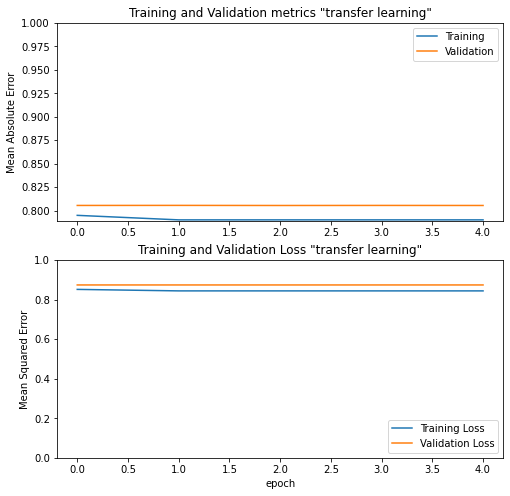

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Mean Absolute Error')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation metrics "transfer learning"')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Mean Squared Error')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss "transfer learning"')
plt.xlabel('epoch')
plt.savefig("TL_engineering_rnn.jpg")
plt.show()

Fine_Tuning

In [561]:
conv_model.trainable = True

In [562]:
len(conv_model.layers)

6

In [563]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(conv_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 2

# Freeze all the layers before the `fine_tune_at` layer
for layer in conv_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  6


In [564]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [565]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])